In [1]:
const Float = Float64


"""
    Particle type
`nDim::Int`: dimension of the parameter space to be explored
`position::Array{Float, 1}`: current position of the particle
`velocity::Array{Float, 1}`: current velocity of the particle
`pBest::Array{Float, 1}`: the position at which the particle has 
the best-fit value through particle's history
`lBest::Array{Float, 1}`: the position at which the local group has 
the best-fit value through local group's history
`fitValue::Float`: the fit-value at current position
`fitpBest::Float`: the fit-value at `pBest`
`fitlBest::Float`: the fit-value at `lBest`
`nFitEval::Int`: number of the evaluation of the fitness function 
(which does not take the steps outside the parameter space into account)
"""
mutable struct Particle
    nDim::Int
    
    position::Array{Float, 1}
    velocity::Array{Float, 1}
    pBest::Array{Float, 1}
    lBest::Array{Float, 1}
    
    fitValue::Float
    fitpBest::Float
    fitlBest::Float
    
    nFitEval::Int
    
    # initialize the particle
    # with the lBest = pBest = position = random numbers
    # and fitlBest = fitpBest = fitValue = Inf
    # These setups will be updated by the initiation of the swarm
    function Particle(nDim::Int)
        position = rand(nDim)
        velocity = rand(nDim) - position
        pBest = position
        lBest = position
        
        fitValue = Inf
        fitpBest = fitValue
        fitlBest = fitValue
        
        nFitEval = 0
        
        new(nDim, position, velocity, pBest, lBest, 
            fitValue, fitpBest, fitlBest, nFitEval)
    end       
end

# test
# p1 = Particle(4)


"""
    initFitValue!(fitFunc::Function, p::Particle)
Initiate the `fitValue` for the `p` particle using the fitness 
function `fitFunc`.
"""
function initFitValue!(fitFunc::Function, p::Particle)
    p.fitValue = fitFunc(p.position)
    
    # update nFitEval
    p.nFitEval += 1
    nothing
end

# test
# fitFunc(x) = x[1]^2 + x[2]^2
# p2 = Particle(2)
# println(p2)
# initFitValue!(fitFunc, p2)
# println(p2)


"""
    updatePositionAndFitValue!(fitFunc::Function, nDim::Int, p::Particle)
Update the `position` and `fitValue` for the `p` particle using 
the fitness function `fitFunc` with `nDim` parameters.
"""
function updatePositionAndFitValue!(fitFunc::Function, p::Particle)
    p.position += p.velocity
    
    # if position is outside the paramter space, we set fitValue = Inf
    for x in p.position
        if (x < 0 || x > 1)
            p.fitValue = Inf
            return
        end
    end
    # update nFitEval
    p.nFitEval += 1
    p.fitValue = fitFunc(p.position)
    
    nothing
end

# test
# fitFunc(x) = x[1]^2 + x[2]^2
# p2 = Particle(2)
# println(p2)
# initFitValue!(fitFunc, p2)
# println(p2)
# updatePositionAndFitValue!(fitFunc, p2, 2.0, 2.0)
# println(p2)


"""
    updatepBestAndFitpBest!(p::Particle)
Update the `pBest` and `fitpBest` for `p` particle.
"""
function updatepBestAndFitpBest!(p::Particle)
    if p.fitValue < p.fitpBest 
        p.fitpBest  = p.fitValue
        p.pBest = p.position
    end
    nothing
end

# test
# fitFunc(x) = x[1]^2 + x[2]^2
# p2 = Particle(2)
# println(p2)
# updateFitValue!(fitFunc, 2, p2)
# println(p2)
# updatepBestAndFitpBest!(p2)
# println(p2)



"""
    updateVelocity!(p::Particle, w::Float, c1::Float=c1, c2::Float=c2)
Update the `velocity` of the particle.
"""
function updateVelocity!(p::Particle, w::Float, c1::Float, c2::Float)
    p.velocity = w * p.velocity + 
    c1 * rand() * (p.pBest - p.position) + 
    c2 * rand() * (p.lBest - p.position)
    
    nothing
end

# test
# updateVelocity!(p1, 0.8, 2, 2)


"""
    neiborIndices(i::Int, nNeighbor::Int, nParticle::Int)
Return the indices for the `nNeighbor` neiborhoods of the `i`th particle
in a swarm with `nParticle` particles.
"""
function neiborIndices(i::Int, nNeibor::Int, nParticle::Int)
    
    # number of neighbors should be larger than 3
    nNeibor = max(3, nNeibor)
    
    # number of neighbors on the left side of i-th particle
    nLeft = (nNeibor - 1) ÷ 2
    
    # the index of the starting particle in the local group
    startIndex = (i - nLeft)
    
    # the index of the ending particle in the local group
    endIndex = startIndex + nNeibor -1
    
    # indices for the local group
    indices = collect(startIndex:endIndex)
    
    # ajust the indices to be in the range(1:nParticle)
    for i in 1:nNeibor
        if indices[i] < 1
            indices[i] += nParticle
        elseif indices[i] > nParticle
            indices[i] -= nParticle
        end
    end
    
    indices
end

# test
# neiborIndices(1, 3, 40)  



"""
    Swarm type
`fitFunc::Function`: fitness function to be evaluated
`nDim::Int`: dimension of the parameter space to be explored
`nParticle::Int`: number of particles in a swarm
    
`nNeibor::Int`: number of neighborhoods (particles) in a local group
    
`nInter::Int`: number of iterations for each particles to move forward
`c1::Float`: cognative constant
`c2::Float`: social constant
`wMax::Float`: the maximum value of inertia weight
`wMin::Float`: the minimum value of inertia weight
`w::Float`: the current value of inertia weight
    
`gBest::Array{Float, 1}`: the position at which the swarm has 
the best-fit value through the history
    
`fitgBest::Float`: the fit-value at `gBest`
    
`particles::Array{Particle, 1}`: the particles in a swarm
`nFitEvals::Int`: number of the evaluation of the fitness function 
(which does not take the steps outside the parameter space into account)
"""
mutable struct Swarm
    fitFunc::Function
    nDim::Int
    
    nParticle::Int
    nNeibor::Int
    nInter::Int
    
    c1::Float
    c2::Float
    
    wMax::Float
    wMin::Float
    w::Float
    
    gBest::Array{Float, 1}    
    fitgBest::Float
    
    particles::Array{Particle, 1}
    
    nFitEvals::Int
    
    # initialize the swarm
    function Swarm(fitFunc::Function, nDim::Int; 
            nParticle::Int=40, 
            nNeibor::Int=3, nInter::Int=2000,
            c1::Float=2.0, c2::Float=2.0,
            wMax::Float=0.9, wMin::Float=0.4)
        
        if nNeibor > nParticle
            error("Number of particles in a local group should not exceed 
                the totoal number of particles in the swarm!")
        end    
        
        w = wMax
        
        gBest = rand(nDim)
        fitgBest = Inf
        
        # initialize the swarm with nParticle
        particles = [Particle(nDim) for i in 1:nParticle]
        
        
        nFitEvals = 0
                
        new(fitFunc, nDim, nParticle, nNeibor, nInter, 
            c1, c2, wMax, wMin, w, gBest, 
            fitgBest, particles, nFitEvals)        
    end       
end

# test
# fitFunc(x) = x[1]^2 + x[2]^2
# nDim = 2
# s = Swarm(fitFunc, nDim)


"""
    updatelBestAndFitlBest!(s::Swarm)
Update lBest and fitlBest for each particle in the swarm `s`.
"""        
function updatelBestAndFitlBest!(s::Swarm)
    for i in 1:s.nParticle
        neiborIds = neiborIndices(i, s.nNeibor, s.nParticle)
        neiborFits = [s.particles[Id].fitValue for Id in neiborIds]
        fitlBest, index = findmin(neiborFits)
        
        if fitlBest < s.particles[i].fitlBest
            # neibor == local group
            lBest = s.particles[neiborIds[index]].position
            s.particles[i].lBest = lBest
            s.particles[i].fitlBest = fitlBest
        end
    end
    nothing
end

# test
# fitFunc(x) = x[1]^2 + x[2]^2
# nDim = 2
# s = Swarm(fitFunc, nDim)  
# updatelBestAndFitlBest!(s)
# s.particles[1]



"""
    updategBestAndFitgBest!(s::Swarm)
Update gBest and fitgBest for the swarm `s`.
"""        
function updategBestAndFitgBest!(s::Swarm)
    
    gFits = [particle.fitValue for particle in s.particles]
    fitgBest, index = findmin(gFits)
    if fitgBest < s.fitgBest
        s.gBest = s.particles[index].position   
        s.fitgBest = fitgBest
    end
    nothing
end

# test
# fitFunc(x) = x[1]^2 + x[2]^2
# nDim = 2
# s = Swarm(fitFunc, nDim)  
# updategBestAndFitgBest!(s)
# s.gBest


"""
    initSwarm(s::Swarm)
Initiation (0st iteration) the swarm `s`.
"""
function initSwarm(s::Swarm)
    
    # initiate the fitValue for each particle
    for particle in s.particles
        initFitValue!(s.fitFunc, particle)
        updatepBestAndFitpBest!(particle)
    end
    
    # update lBest and fitlBest for the swarm
    updatelBestAndFitlBest!(s)
    
    # update gBest and fitgBest for the swarm
    updategBestAndFitgBest!(s)
    
    nothing
end

# test
# fitFunc(x) = x[1]^2 + x[2]^2
# nDim = 2
# s = Swarm(fitFunc, nDim, nParticle=4)
# initSwarm(s)
# s



"""
    updateInertia!(s::Swarm)
Update the inertia weight after each iteration.
"""
function updateInertia!(s::Swarm)
    dw = (s.wMax - s.wMin)/s.nInter
    s.w -= dw
    
    nothing
end

# test
# fitFunc(x) = x[1]^2 + x[2]^2
# nDim = 2
# s = Swarm(fitFunc, nDim, nParticle=4)
# updateInertia!(s)
# s.w


"""
    updateVelocity!(s::Swarm)
Update the `velocity` for each particle in the swarm `s`.
"""
function updateVelocity!(s::Swarm)
    for particle in s.particles
        updateVelocity!(particle, s.w, s.c1, s.c2)
    end        
    nothing
end

# test
# fitFunc(x) = x[1]^2 + x[2]^2
# nDim = 2
# s = Swarm(fitFunc, nDim, nParticle=4)
# initSwarm(s)
# println(s.particles[1])
# updateVelocity!(s)
# println(s.particles[1])


"""
    updatePositionAndFitValue!(s::Swarm)
Update the `position` and `fitValue` for each particle in the swarm `s`.
"""
function updatePositionAndFitValue!(s::Swarm)
    for particle in s.particles
        updatePositionAndFitValue!(s.fitFunc, particle)
    end        
    nothing
end

# test
# fitFunc(x) = x[1]^2 + x[2]^2
# nDim = 2
# s = Swarm(fitFunc, nDim, nParticle=4)
# initSwarm(s)
# println(s.particles[1])
# updatePositionAndFitValue!(s)
# println(s.particles[1])



"""
    updateSwarm(s::Swarm)
One iteration for the swarm `s`.
"""
function updateSwarm(s::Swarm)
    # update the velocity for each particle in the swarm
    updateVelocity!(s::Swarm)
    
    # update the position and fitValue for each particle in the swarm
    updatePositionAndFitValue!(s::Swarm)
    
    # update the lBest and fitlBest for each particle in the swarm
    updatelBestAndFitlBest!(s::Swarm)
    
    # update the gBest and fitgBest for the swarm
    updategBestAndFitgBest!(s::Swarm) 
    
    # update the inertia weigh w for each particle in the swarm
    updateInertia!(s::Swarm)
    
    nothing 
end

# test
# fitFunc(x) = x[1]^2 + x[2]^2
# nDim = 2
# s = Swarm(fitFunc, nDim, nParticle=4)
# initSwarm(s)
# println(s.particles[1])
# updateSwarm(s)
# println(s.particles[1])
# updateSwarm(s)
# println(s.particles[1])

updateSwarm

In [2]:
using Plots
using LaTeXStrings

In [3]:
function onePsoRun(fitFunc::Function, nDim::Int; nParticle=100, nInter::Int=4000)
    s = Swarm(fitFunc, nDim, nParticle=nParticle, nInter=nInter)
    initSwarm(s)
    
    for i in s.nInter
        updateSwarm(s)
    end
    s.gBest
end

fitFunc(x) = (x[1]-1/2)^2 + (x[2]-1/2)^2
nDim = 2

nParticle = 100
nInter = 4000
nRun = 200
xs = Array{Float}(undef, nRun)
ys = zeros(nRun)
for i in 1:nRun
    xs[i], ys[i] = onePsoRun(fitFunc, nDim, nParticle=nParticle, nInter=nInter)
end

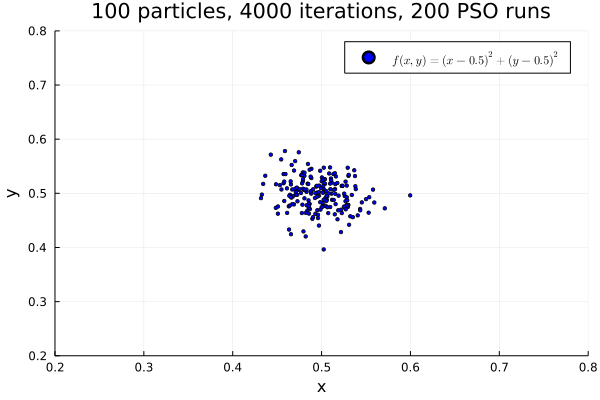

In [4]:
gr()
scatter(xs, ys, markersize=2, c=:blue, xlims = (0.2,0.8), ylims = (0.2,0.8), 
label = L"f(x,y) = (x-0.5)^2 + (y-0.5)^2",
title = "$nParticle particles, $nInter iterations, $nRun PSO runs")
xlabel!("x")
ylabel!("y")

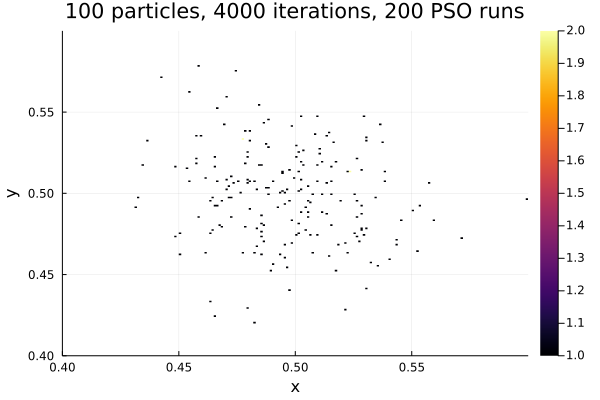

In [5]:
histogram2d(xs, ys,nbins=300, xlims = (0.4,0.6), ylims = (0.4,0.6), 
label = L"f(x,y) = (x-0.5)^2 + (y-0.5)^2",
title = "$nParticle particles, $nInter iterations, $nRun PSO runs")
xlabel!("x")
ylabel!("y")

In [19]:
nInter_2 = 1
nRun_2 = 1
xs_2 = Array{Float}(undef, nRun)
ys_2 = zeros(nRun)
for i in 1:nRun
    xs_2[i], ys_2[i] = onePsoRun(fitFunc, nDim, nParticle=nParticle, nInter=nInter)
end

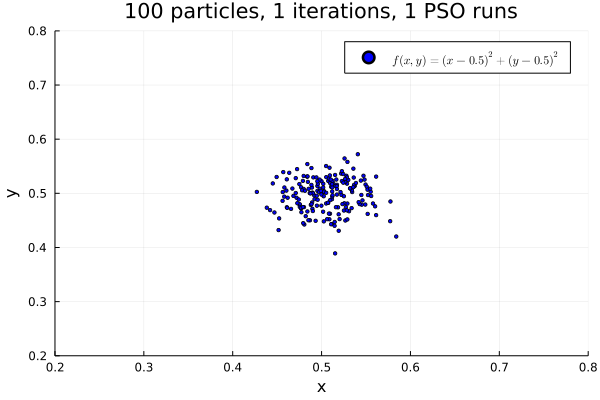

In [20]:
gr()
scatter(xs_2, ys_2, markersize=2, c=:blue, xlims = (0.2,0.8), ylims = (0.2,0.8), 
label = L"f(x,y) = (x-0.5)^2 + (y-0.5)^2",
title = "$nParticle particles, $nInter_2 iterations, $nRun_2 PSO runs")
xlabel!("x")
ylabel!("y")